In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision import datasets, transforms
from torch import nn
import IPython


In [2]:
torch.__version__

'0.3.1'

In [3]:
class Config:
    lr = 0.00005
    noise_dim = 64 # noise dimension
    image_size = 64
    image_size2 = 64
    num_channels = 3 # chanel of img 
    ngf = 64 # generate channel
    ndf = 64 # discriminative channel
    beta1 = 0.5
    batch_size = 32
    max_epoch = 2000
    critic_steps = 5
    clamp = 0.01
    
opt=Config()


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
import os
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(opt.image_size),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(opt.image_size),
        transforms.ToTensor(),
    ]),
}

data_dir = 'fruits/fruits-360/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [5]:
BATCH_SIZE = opt.batch_size
data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.ConcatDataset([image_datasets['train'], image_datasets['val']]),
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                          num_workers=3, pin_memory = True)
# pin_memory if you're on GPU

In [6]:
n_batches = int(np.ceil(data_loader.dataset.cumulative_sizes[1]/ BATCH_SIZE)) # 60000 / 100


In [8]:

generator = nn.Sequential(
            nn.ConvTranspose2d(opt.noise_dim,opt.ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(opt.ngf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*8,opt.ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*4,opt.ngf*2,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*2,opt.ngf,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf,opt.num_channels,4,2,1,bias=False),
            nn.Tanh()
        )

critic = nn.Sequential(
            nn.Conv2d(opt.num_channels,opt.ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf,opt.ndf*2,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*2,opt.ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*4,opt.ndf*8,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*8,1,4,1,0,bias=False),
            # Modification 1: remove sigmoid
            # nn.Sigmoid()
        )
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
#     else:print(class_name)

critic.apply(weight_init)
generator.apply(weight_init)
# if you're running on GPU, move models there
if torch.cuda.is_available():
    critic.cuda()
    generator.cuda()

In [9]:

# These are the recommended defaults (sauf N_EPOCHS) from the WGAN paper.# These  
LR = opt.lr
N_EPOCHS = opt.max_epoch
N_CRITIC_STEPS = opt.critic_steps
CLAMP = opt.clamp

In [10]:
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

In [11]:
from torch.autograd import Variable

def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [12]:

import  torch.nn.functional  as F
from torchvision.utils import save_image

def denorm(x):
    # convert back from [-1, 1] to [0, 1]
    out = (x + 1) / 2
    return out #out.clamp(0, 1)

In [19]:
x = torch.randn(batch_size, opt.noise_dim, 1, 1)

In [20]:
print(x.shape)

torch.Size([32, 64, 1, 1])


In [23]:
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            images = to_var(images)

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, opt.noise_dim, 1, 1))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, opt.noise_dim, 1, 1))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

        if (epoch) % 30 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            critic_loss.data[0],
                            generator_loss.data[0],
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
            if (epoch + 1) == 1:
                images = images.view(images.size(0), opt.num_channels, opt.image_size, opt.image_size) # reshape
                IPython.display.Image(denorm(images.data))
                save_image(denorm(images.data), './datadcwgan//wgan_real_images.png')

        # Save sampled images
        # Save sampled images
            fake_images = fake_images.view(fake_images.size(0), opt.num_channels, opt.image_size, opt.image_size) #reshape
            IPython.display.Image(denorm(fake_images.data))
            save_image(denorm(fake_images.data), './datadcwgan//wgan_fake_images-%0.3d.png' %(epoch + 1))

        # Save the trained parameters 
            torch.save(generator.state_dict(), './dcwganweights/wgan_generator-%0.3d.pkl' %(epoch + 1))
            torch.save(critic.state_dict(), './dcwganweights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print ('Training ended early.')

Epoch [0/2000], Step[1426/1426], d_loss: -0.6355, g_loss: 0.1819, Mean D(x): 0.24, Mean D(G(z)): -0.40
Epoch [30/2000], Step[1426/1426], d_loss: 0.0223, g_loss: 0.1546, Mean D(x): -0.24, Mean D(G(z)): -0.22
Epoch [60/2000], Step[1426/1426], d_loss: -0.3679, g_loss: -0.0708, Mean D(x): 0.31, Mean D(G(z)): -0.06
Epoch [90/2000], Step[1426/1426], d_loss: -0.3412, g_loss: 0.2587, Mean D(x): -0.16, Mean D(G(z)): -0.50
Epoch [120/2000], Step[1426/1426], d_loss: -0.3445, g_loss: -0.1514, Mean D(x): 0.28, Mean D(G(z)): -0.07
Epoch [150/2000], Step[1426/1426], d_loss: -0.2466, g_loss: 0.1487, Mean D(x): 0.20, Mean D(G(z)): -0.05
Epoch [180/2000], Step[1426/1426], d_loss: -0.1924, g_loss: 0.3373, Mean D(x): 0.13, Mean D(G(z)): -0.07
Epoch [210/2000], Step[1426/1426], d_loss: -0.2946, g_loss: 0.3710, Mean D(x): 0.25, Mean D(G(z)): -0.04
Epoch [240/2000], Step[1426/1426], d_loss: -0.2281, g_loss: 0.2175, Mean D(x): 0.06, Mean D(G(z)): -0.17
Epoch [270/2000], Step[1426/1426], d_loss: -0.2204, g_los

In [24]:
# Load back saved weights (we have these pre-trained)
generator.load_state_dict(torch.load('dcwganweights/wgan_generator-1981.pkl'))
critic.load_state_dict(torch.load('dcwganweights/wgan_discriminator-1981.pkl'))

In [26]:
NB_SAMPLES = 40
z = to_var(torch.randn(NB_SAMPLES, 64, 1, 1))
fake_images = generator(z)

In [28]:
save_image(denorm(fake_images.view(fake_images.size(0), 3, 64, 64).data), # reshape
           './data/wgan_fake_images_final.png', nrow=20)

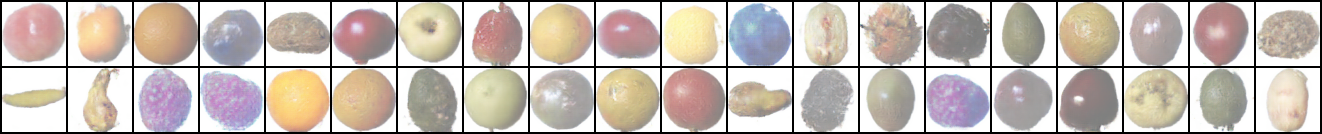

In [29]:
IPython.display.Image('./data/wgan_fake_images_final.png')